In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json


plt.style.use("seaborn-v0_8")


In [2]:
with open("workouts_export.json", "r") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data["workouts"])


In [4]:
df = pd.DataFrame(data["workouts"])

# Check columns
print(df.columns)

Index(['id', 'type', 'date', 'duration', 'avgHeartRate', 'sets', 'reps',
       'weight', 'volume', 'distance', 'cadence', 'avgSpeed', 'avgPower',
       'cyclingCadence'],
      dtype='object')


In [5]:
# Convert date column safely
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Remove rows where date failed
df = df.dropna(subset=["date"])

In [6]:
# Sort
df = df.sort_values("date")

df.head()

,id,type,date,duration,avgHeartRate,sets,reps,weight,volume,distance,cadence,avgSpeed,avgPower,cyclingCadence
22,0589e6a5-2309-4e46-adbe-b482910b3a2e,running,2026-01-27,40,135,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
21,288524e6-9e43-4fce-845a-d564e1e7799f,weightlifting,2026-02-01,60,120,5.0,8.0,100.0,4000.0,NaN,NaN,NaN,NaN,NaN
20,782e7a71-b813-4d0f-b2fa-cc402476b140,weightlifting,2026-02-02,60,120,5.0,8.0,100.0,4000.0,NaN,NaN,NaN,NaN,NaN
19,98d87e1a-cfe7-49f1-9397-8d1d5ebcb875,weightlifting,2026-02-02,60,120,10.0,2.0,100.0,2000.0,NaN,NaN,NaN,NaN,NaN
18,7eadbf9d-66a9-452e-99f9-0c919b0a612a,running,2026-02-04,40,135,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [7]:
running = df[df["type"] == "running"]
cycling = df[df["type"] == "cycling"]
weightlifting = df[df["type"] == "weightlifting"]

print("Running workouts:", len(running))
print("Cycling workouts:", len(cycling))
print("Weightlifting workouts:", len(weightlifting))


Running workouts: 15
Cycling workouts: 2
Weightlifting workouts: 6


In [8]:
def calculate_training_load(row):
    if pd.notna(row["avgHeartRate"]):
        intensity = row["avgHeartRate"] / 190   # assume max HR
    else:
        intensity = 0.7
        
    return row["duration"] * intensity

In [9]:
df["week"] = df["date"].dt.to_period("W")

weekly_load = df.groupby("week")["duration"].sum().reset_index()

weekly_load["week"] = weekly_load["week"].astype(str)

weekly_load


,week,duration
0,2026-01-26/2026-02-01,100
1,2026-02-02/2026-02-08,830
2,2026-02-09/2026-02-15,570


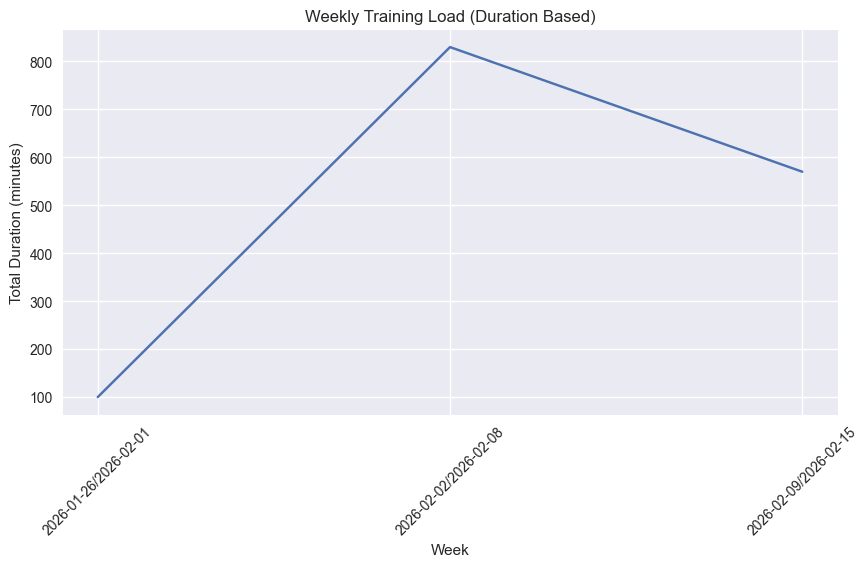

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(weekly_load["week"], weekly_load["duration"])
plt.xticks(rotation=45)
plt.title("Weekly Training Load (Duration Based)")
plt.xlabel("Week")
plt.ylabel("Total Duration (minutes)")
plt.show()


In [11]:
df["trainingLoad"] = df.apply(calculate_training_load, axis=1)

df[["date","duration","avgHeartRate","trainingLoad"]]

,date,duration,avgHeartRate,trainingLoad
22,2026-01-27,40,135,28.421053
21,2026-02-01,60,120,37.894737
20,2026-02-02,60,120,37.894737
19,2026-02-02,60,120,37.894737
18,2026-02-04,40,135,28.421053
17,2026-02-05,30,135,21.315789
16,2026-02-05,40,135,28.421053
15,2026-02-05,45,140,33.157895
14,2026-02-05,180,120,113.684211
13,2026-02-05,40,135,28.421053


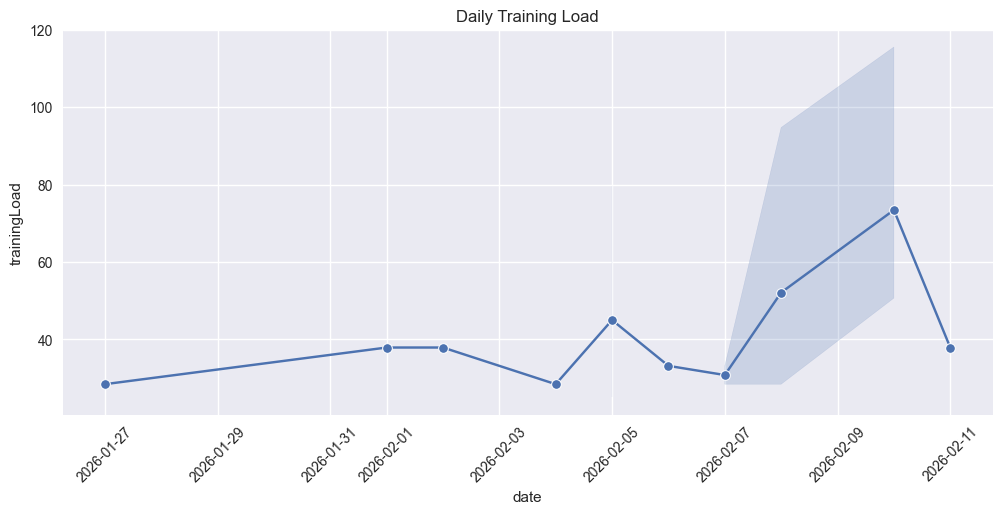

In [12]:
plt.figure(figsize=(12,5))
sns.lineplot(x="date", y="trainingLoad", data=df, marker="o")
plt.title("Daily Training Load")
plt.xticks(rotation=45)
plt.show()


In [13]:
# 7-day rolling average (Acute Load)
df["acute_load"] = df["trainingLoad"].rolling(window=7).mean()

# 28-day rolling average (Chronic Load)
df["chronic_load"] = df["trainingLoad"].rolling(window=28).mean()

# ACWR
df["ACWR"] = df["acute_load"] / df["chronic_load"]

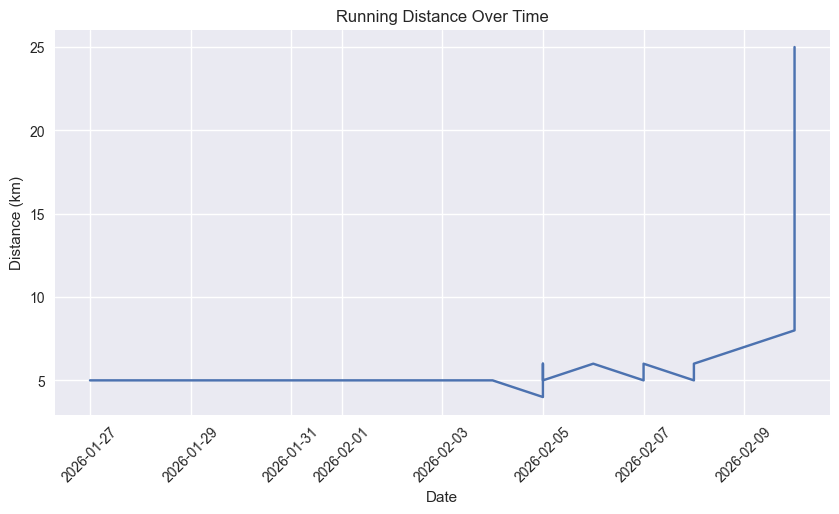

In [14]:
# Running Distance Over Time
plt.figure(figsize=(10,5))
plt.plot(pd.to_datetime(running["date"]), running["distance"])
plt.title("Running Distance Over Time")
plt.xlabel("Date")
plt.ylabel("Distance (km)")
plt.xticks(rotation=45)
plt.show()


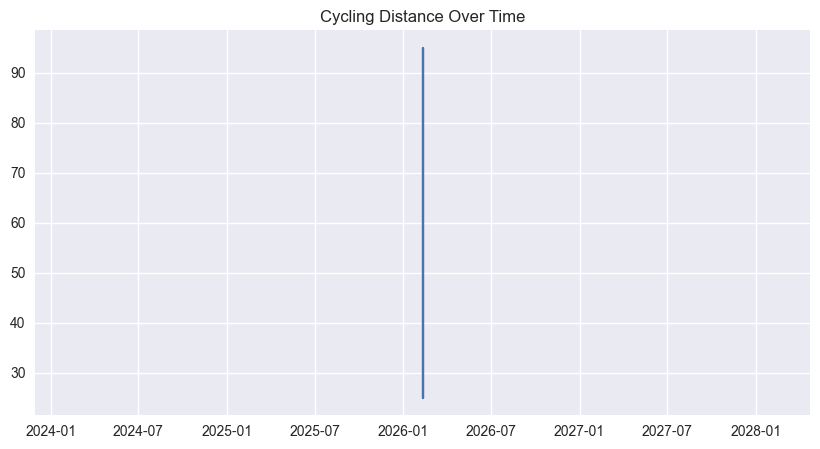

In [15]:
plt.figure(figsize=(10,5))
plt.plot(pd.to_datetime(cycling["date"]), cycling["distance"])
plt.title("Cycling Distance Over Time")
plt.show()


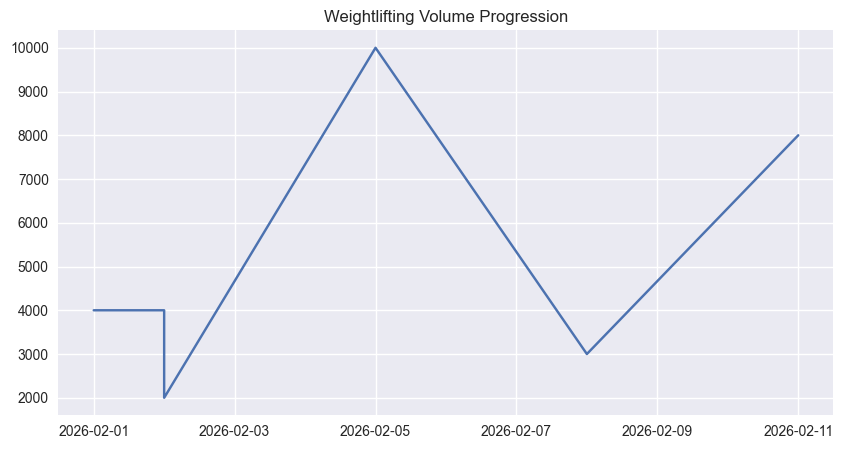

In [16]:
plt.figure(figsize=(10,5))
plt.plot(pd.to_datetime(weightlifting["date"]), weightlifting["volume"])
plt.title("Weightlifting Volume Progression")
plt.show()


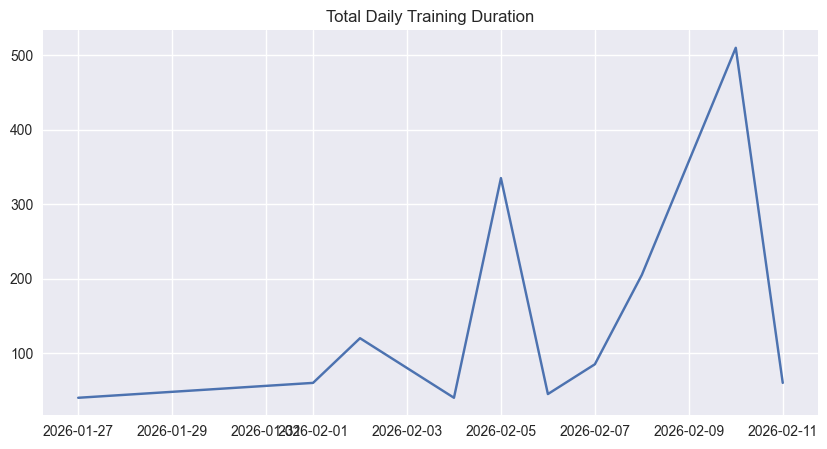

In [17]:
df["date"] = pd.to_datetime(df["date"])

daily_load = df.groupby("date")["duration"].sum()

plt.figure(figsize=(10,5))
plt.plot(daily_load.index, daily_load.values)
plt.title("Total Daily Training Duration")
plt.show()


In [18]:
# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"])

# Calculate daily training load first (if not already)
df["trainingLoad"] = df["duration"] * (df["avgHeartRate"] / 190)

# Weekly aggregation (Monday as start)
weekly_df = df.resample("W-MON", on="date")["trainingLoad"].sum().reset_index()

weekly_df.rename(columns={"trainingLoad": "weeklyLoad"}, inplace=True)

weekly_df.head()


,date,weeklyLoad
0,2026-02-02,142.105263
1,2026-02-09,504.473684
2,2026-02-16,478.421053


In [19]:
df["load_change_%"] = df["trainingLoad"].pct_change() * 100

# Flag spike if > 30% increase
df["spike_flag"] = df["load_change_%"] > 30


In [20]:
mean_load = df["trainingLoad"].mean()
std_load = df["trainingLoad"].std()

df["z_score"] = (df["trainingLoad"] - mean_load) / std_load

# Flag if load > 2 standard deviations
df["stat_spike"] = df["z_score"] > 2


In [21]:
weekly_variability = df.resample("W-MON", on="date")["trainingLoad"].std().reset_index()
weekly_variability.rename(columns={"trainingLoad": "weekly_std"}, inplace=True)

weekly_variability.head()


,date,weekly_std
0,2026-02-02,4.736842
1,2026-02-09,29.514694
2,2026-02-16,47.704634


In [22]:
weekly_stats = df.resample("W-MON", on="date").agg({
    "trainingLoad": ["mean", "std", "sum"]
}).reset_index()

weekly_stats.columns = ["date", "mean_load", "std_load", "weekly_load"]

# Monotony
weekly_stats["monotony"] = weekly_stats["mean_load"] / weekly_stats["std_load"]

# Strain
weekly_stats["strain"] = weekly_stats["weekly_load"] * weekly_stats["monotony"]

weekly_stats.head()


,date,mean_load,std_load,weekly_load,monotony,strain
0,2026-02-02,35.526316,4.736842,142.105263,7.500000,1065.789474
1,2026-02-09,42.039474,29.514694,504.473684,1.424357,718.550840
2,2026-02-16,68.345865,47.704634,478.421053,1.432688,685.428183


In [23]:
# Step 1 — Ensure Data Is Sorted
df = df.sort_values("date")

# Step 2 — Calculate Acute Load (7-day rolling mean)
df["acute_load"] = df["trainingLoad"].rolling(window=7, min_periods=1).mean()

# Step 3 — Calculate Chronic Load (28-day rolling mean)
df["chronic_load"] = df["trainingLoad"].rolling(window=28, min_periods=1).mean()

# Step 4 — Calculate ACWR
df["ACWR"] = df["acute_load"] / df["chronic_load"]

# Step 5 — Clean Infinite / NaN
df["ACWR"] = df["ACWR"].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["ACWR"])

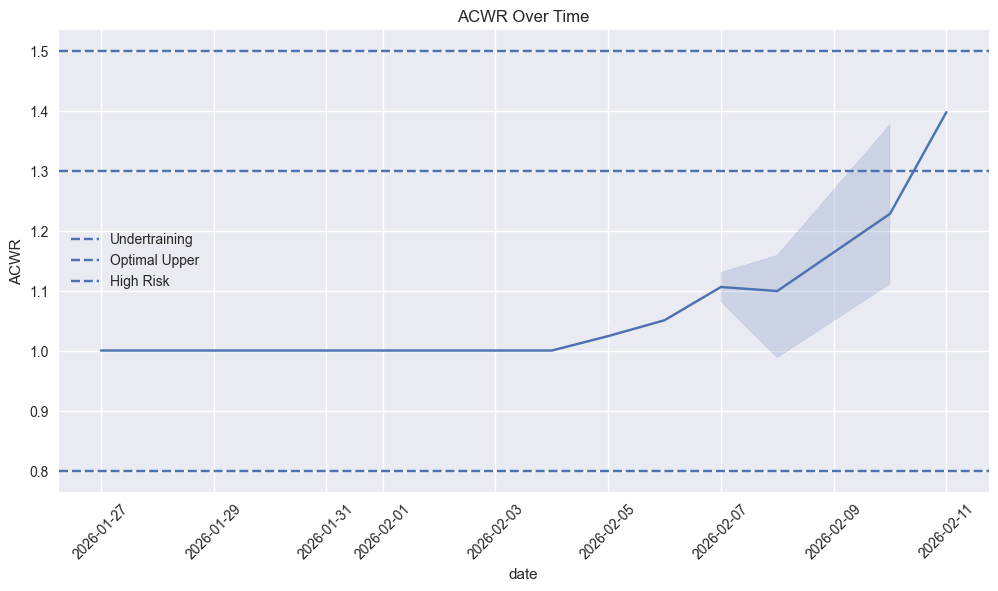

In [24]:
plt.figure(figsize=(12,6))
sns.lineplot(x="date", y="ACWR", data=df)

plt.axhline(0.8, linestyle="--", label="Undertraining")
plt.axhline(1.3, linestyle="--", label="Optimal Upper")
plt.axhline(1.5, linestyle="--", label="High Risk")

plt.title("ACWR Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.show()


Phase 1 — Descriptive Analytics

Now we move to Phase 2 — Scientific Analytics

In [25]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Graph:

# X = date
# Y = injury probability %

# 📊 Research impact:
# Predictive injury modelling


In [26]:
summary = df.select_dtypes(include="number").describe()
summary


,duration,avgHeartRate,sets,reps,weight,volume,distance,cadence,avgSpeed,avgPower,cyclingCadence,trainingLoad,acute_load,chronic_load,ACWR,load_change_%,z_score
count,23.000000,23.000000,6.000000,6.000000,6.000000,6.000000,17.000000,8.000000,0.0,2.0,2.0,23.000000,23.000000,23.000000,23.000000,22.000000,2.300000e+01
mean,65.217391,139.347826,7.500000,7.666667,93.333333,5166.666667,13.352941,168.750000,NaN,210.0,90.0,48.913043,42.935110,38.273566,1.106299,24.696388,2.654881e-16
std,40.689463,15.322618,2.738613,2.943920,16.329932,3125.166662,22.002674,5.175492,NaN,0.0,0.0,35.182127,11.642320,5.340754,0.143478,89.038380,1.000000e+00
min,30.000000,120.000000,5.000000,2.000000,60.000000,2000.000000,4.000000,165.000000,NaN,210.0,90.0,21.315789,28.421053,28.421053,0.987964,-78.378378,-7.844112e-01
25%,40.000000,135.000000,5.000000,8.000000,100.000000,3250.000000,5.000000,165.000000,NaN,210.0,90.0,28.421053,34.421053,34.421053,1.000000,-16.571429,-5.824546e-01
50%,60.000000,135.000000,7.500000,8.000000,100.000000,4000.000000,6.000000,167.500000,NaN,210.0,90.0,37.894737,41.616541,38.486842,1.052181,0.000000,-3.131791e-01
75%,60.000000,150.000000,10.000000,9.500000,100.000000,7000.000000,8.000000,170.000000,NaN,210.0,90.0,48.947368,44.041353,41.136481,1.152595,19.892473,9.756358e-04
max,180.000000,185.000000,10.000000,10.000000,100.000000,10000.000000,95.000000,180.000000,NaN,210.0,90.0,175.263158,76.466165,49.413876,1.547463,258.064516,3.591315e+00


In [27]:
# Ensure fatigueScore exists
if "fatigueScore" not in df.columns:
    df["fatigueScore"] = df["trainingLoad"].rolling(7, min_periods=1).mean()

# Readiness score
df["readiness"] = 100 - df["fatigueScore"]

df[["date","fatigueScore","readiness"]].head()


,date,fatigueScore,readiness
22,2026-01-27,28.421053,71.578947
21,2026-02-01,33.157895,66.842105
20,2026-02-02,34.736842,65.263158
19,2026-02-02,35.526316,64.473684
18,2026-02-04,34.105263,65.894737


Query - 1

In [37]:
print(df.columns.tolist())


['count', 'workouts']


In [40]:
import pandas as pd
import json

with open("workouts_export.json") as f:
    raw = json.load(f)

df = pd.DataFrame(raw["workouts"])   # ← THIS is the fix

print(df.columns)
df.head(10)


Index(['id', 'type', 'date', 'duration', 'avgHeartRate', 'sets', 'reps',
       'weight', 'volume', 'distance', 'cadence', 'avgSpeed', 'avgPower',
       'cyclingCadence'],
      dtype='object')


,id,type,date,duration,avgHeartRate,sets,reps,weight,volume,distance,cadence,avgSpeed,avgPower,cyclingCadence
0,11d0f47d-5cb0-4c75-9885-6c756cb9b142,weightlifting,2026-02-11,60,120,10.0,8.0,100.0,8000.0,NaN,NaN,NaN,NaN,NaN
1,ec676300-cc02-457e-80d1-d52ee2e997d6,running,2026-02-10,180,185,NaN,NaN,NaN,NaN,25.0,180.0,NaN,NaN,NaN
2,7f24e3b1-cffb-429a-83b7-480ba218f8de,running,2026-02-10,60,155,NaN,NaN,NaN,NaN,8.0,170.0,NaN,NaN,NaN
3,918505d8-66f8-446f-ab81-8e434acbb823,cycling,2026-02-10,75,150,NaN,NaN,NaN,NaN,95.0,NaN,NaN,210.0,90.0
4,516ddead-a568-4996-8279-f2f18c4ab9b9,cycling,2026-02-10,75,150,NaN,NaN,NaN,NaN,25.0,NaN,NaN,210.0,90.0
5,9db39671-8dbe-4bcb-8f21-56a20f81d2b3,running,2026-02-10,60,155,NaN,NaN,NaN,NaN,8.0,170.0,NaN,NaN,NaN
6,36244b5c-a1e7-4b4d-8bb2-3137d1fc3448,running,2026-02-10,60,155,NaN,NaN,NaN,NaN,8.0,170.0,NaN,NaN,NaN
7,a20b8d3b-92c9-40c0-870f-ede072af14dc,weightlifting,2026-02-08,120,150,5.0,10.0,60.0,3000.0,NaN,NaN,NaN,NaN,NaN
8,ba6a1057-52d6-41d4-971a-fcaf0fda5217,running,2026-02-08,45,140,NaN,NaN,NaN,NaN,6.0,165.0,NaN,NaN,NaN
9,d31d8502-288d-4824-8075-9563f0f80228,running,2026-02-08,40,135,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [41]:
import pandas as pd
import numpy as np

df.columns = df.columns.str.strip().str.lower()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df = df.sort_values("date")
df.head()


,id,type,date,duration,avgheartrate,sets,reps,weight,volume,distance,cadence,avgspeed,avgpower,cyclingcadence
22,0589e6a5-2309-4e46-adbe-b482910b3a2e,running,2026-01-27,40,135,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
21,288524e6-9e43-4fce-845a-d564e1e7799f,weightlifting,2026-02-01,60,120,5.0,8.0,100.0,4000.0,NaN,NaN,NaN,NaN,NaN
20,782e7a71-b813-4d0f-b2fa-cc402476b140,weightlifting,2026-02-02,60,120,5.0,8.0,100.0,4000.0,NaN,NaN,NaN,NaN,NaN
19,98d87e1a-cfe7-49f1-9397-8d1d5ebcb875,weightlifting,2026-02-02,60,120,10.0,2.0,100.0,2000.0,NaN,NaN,NaN,NaN,NaN
18,7eadbf9d-66a9-452e-99f9-0c919b0a612a,running,2026-02-04,40,135,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [42]:
df["trainingload"] = (
    df["duration"].fillna(0) *
    df["avgheartrate"].fillna(120) / 100
)


In [43]:
df["acute_load"] = df["trainingload"].rolling(7, min_periods=1).mean()


In [44]:
df["chronic_load"] = df["trainingload"].rolling(28, min_periods=1).mean()


In [46]:
df["acwr"] = df["acute_load"] / df["chronic_load"]


In [47]:
df["load_change_%"] = df["trainingload"].pct_change() * 100
df["spike_flag"] = df["load_change_%"] > 40


In [48]:
df["z_score"] = (
    (df["trainingload"] - df["trainingload"].mean()) /
    df["trainingload"].std()
)

df["stat_spike"] = df["z_score"] > 2


In [49]:
df["fatiguescore"] = df["trainingload"].rolling(7, min_periods=1).mean()


In [50]:
df["fatiguescore"] = df["trainingload"].rolling(7, min_periods=1).mean()


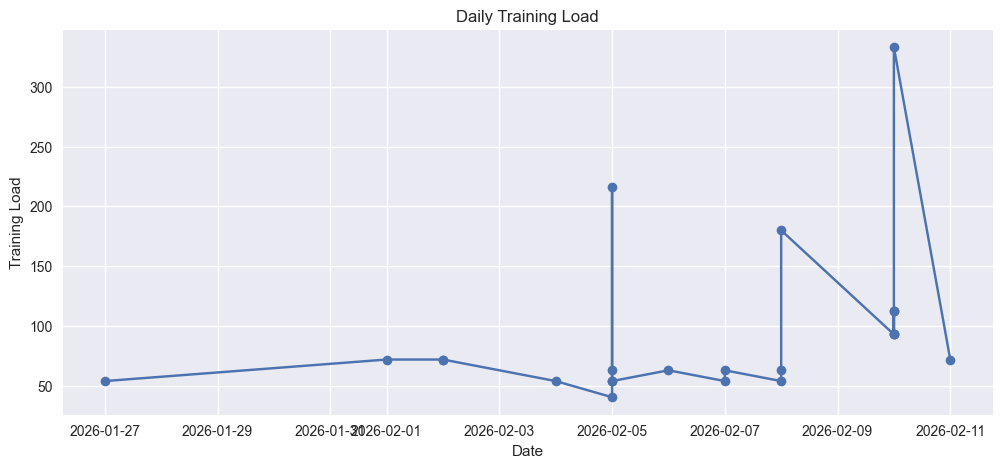

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["trainingload"], marker="o")
plt.title("Daily Training Load")
plt.xlabel("Date")
plt.ylabel("Training Load")
plt.show()


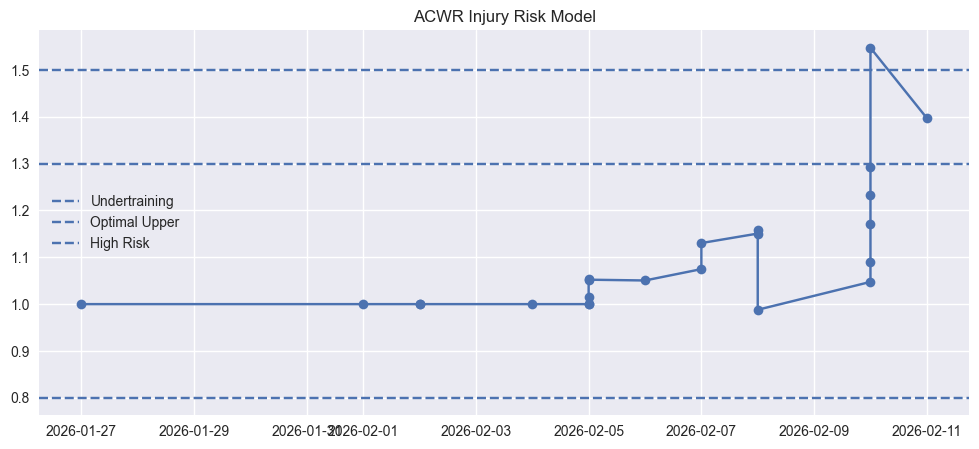

In [52]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["acwr"], marker="o")

plt.axhline(0.8, linestyle="--", label="Undertraining")
plt.axhline(1.3, linestyle="--", label="Optimal Upper")
plt.axhline(1.5, linestyle="--", label="High Risk")

plt.title("ACWR Injury Risk Model")
plt.legend()
plt.show()


In [56]:
df["readiness"] = 100 - df["fatiguescore"]


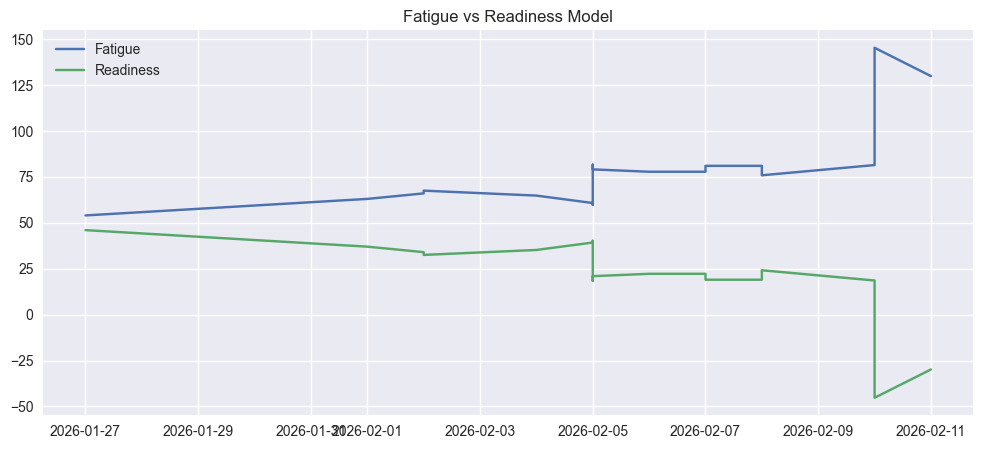

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["fatiguescore"], label="Fatigue")
plt.plot(df["date"], df["readiness"], label="Readiness")
plt.legend()
plt.title("Fatigue vs Readiness Model")
plt.show()


In [58]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# normalize load so sigmoid works properly
df["normalized_load"] = (df["trainingload"] - df["trainingload"].mean()) / df["trainingload"].std()

# injury probability %
df["injury_risk"] = sigmoid(df["normalized_load"]) * 100


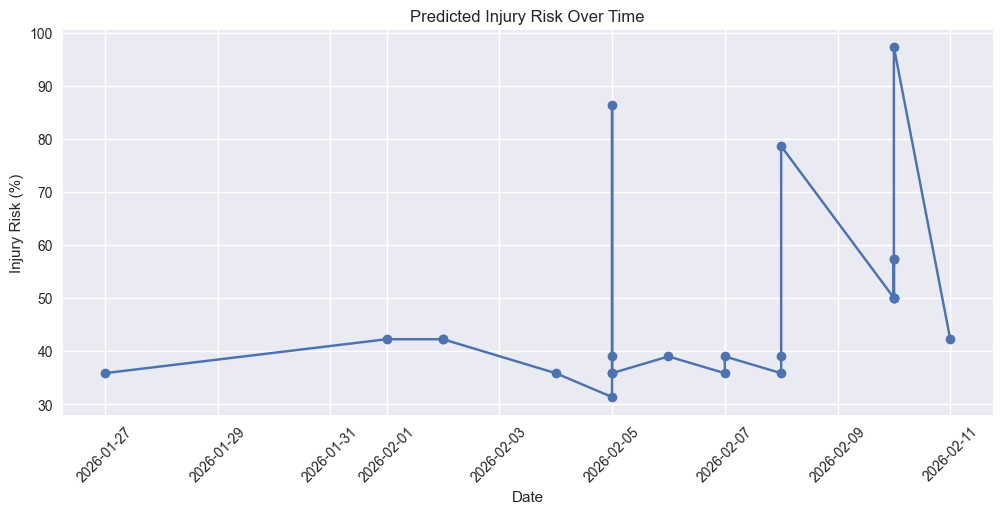

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["injury_risk"], marker="o")

plt.title("Predicted Injury Risk Over Time")
plt.xlabel("Date")
plt.ylabel("Injury Risk (%)")

plt.xticks(rotation=45)
plt.grid(True)
plt.show()


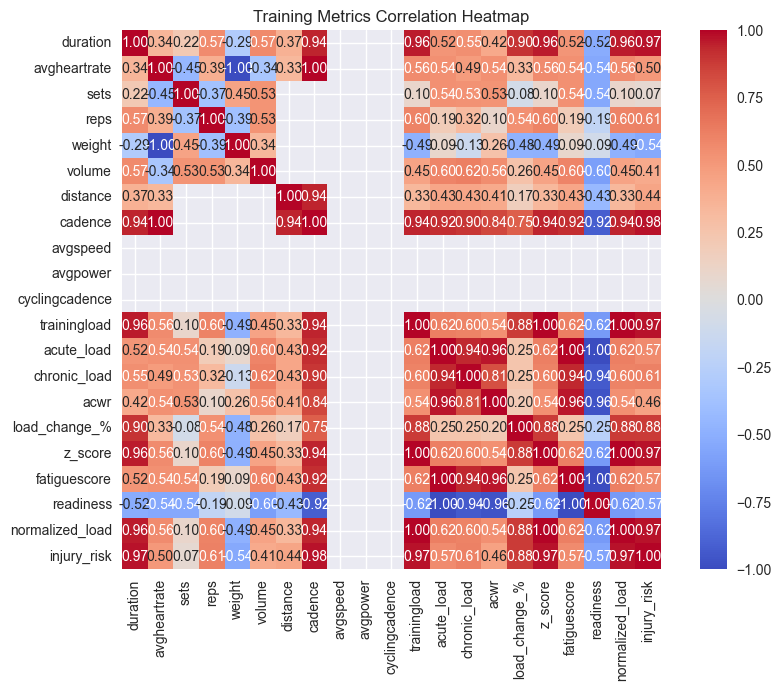

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# select numeric columns only
numeric_df = df.select_dtypes(include=["number"])

plt.figure(figsize=(10,7))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)

plt.title("Training Metrics Correlation Heatmap")
plt.show()
